In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicySimulator, createEnv
from DiffusionLibs import DiffusionPolicyInterface
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="train", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [3]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'rb') as f:
    mdpKernelParams = pickle.load(f)
mdpPolicyOne = MdpKernel()
mdpPolicyOne.load_policy(mdpKernelParams, policyMode="deterministic", randomR=False)
mdpPolicyTwo = MdpKernel()
mdpPolicyTwo.load_policy(mdpKernelParams, policyMode="stochastic", randomR=False)

# ==== Prepare Simulator====
num_windows = 2000
obvMode = "predicted" # "perfect" or "predicted"

policySimulator = PolicySimulator(mdpPolicyOne, env)
simResultOne = policySimulator.runSimulation(mdpPolicyOne, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
'''
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultDeterministic['uRecord'], 
    simResultDeterministic['actionsRecord'], 
    simResultDeterministic['rewardRecord'], 
    simResultDeterministic['uNextRecord']
)
'''
num_windows = 2000
policySimulator = PolicySimulator(mdpPolicyTwo, env)
simResultTwo = policySimulator.runSimulation(mdpPolicyTwo, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
uRecord = np.concatenate((simResultOne['uRecord'], simResultTwo['uRecord']))
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultOne['uRecord'] + simResultTwo['uRecord'], 
    simResultOne['actionsRecord'] + simResultTwo['actionsRecord'], 
    simResultOne['rewardRecord'] + simResultTwo['rewardRecord'], 
    simResultOne['uNextRecord'] + simResultTwo['uNextRecord']
)

Simulation Progress: 100%|██████████| 2000/2000 [00:04<00:00, 416.39it/s, avg reward=0.012083]


In [ ]:
diffusionQParams = {
    'device': 'cuda',
    'gamma': 0.01,
    'tau': 0.005,
    'lr': 5e-3,
    'eta': 1.0,
    'iql_tau': 0.9,
    'temperature': 5.0,
    'N_action_candidates': 100
}
diffusionPolicyInterface = DiffusionPolicyInterface(envParams, **diffusionQParams)
model_state_dict, info = diffusionPolicyInterface.train(
    (uRecord, actionsRecord, rewardRecord, uNextRecord), 
    env, iql_flag=True, epochs=500,batch_size=512, sample_method="greedy")

Evaluation windows: 100%|██████████| 500/500 [00:10<00:00, 47.27it/s]                                                             


Epoch   50/ 500  Avg Ld=0.394346  Avg Lq=31.702421  Avg loss_critic=0.079918  Test packet loss=0.0420  Avg Q_value_check=0.084833


Evaluation windows: 100%|██████████| 500/500 [00:09<00:00, 53.22it/s]                                                             


Epoch  100/ 500  Avg Ld=0.289299  Avg Lq=6.582018  Avg loss_critic=0.000280  Test packet loss=0.0045  Avg Q_value_check=0.011445


Evaluation windows:  12%|█▏        | 60/500 [00:01<00:08, 51.50it/s]                                                              

In [ ]:
# Save the trained model state dictionary
import torch
torch.save(model_state_dict, f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')
print(f"Model saved to Results/DiffusionQ/diffusionQ_config{configIdx}.pth")
with open(f'Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(info, f)
print(f"Info saved to Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl")
with open(f'Results/DiffusionQ/diffusionQ_params_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(diffusionQParams, f)
print(f"Params saved to Results/DiffusionQ/diffusionQ_params_config{configIdx}.pkl")

Model saved to Results/DiffusionQ/diffusionQ_config0.pth
Info saved to Results/DiffusionQ/diffusionQ_info_config0.pkl
Params saved to Results/DiffusionQ/diffusionQ_params_config0.pkl


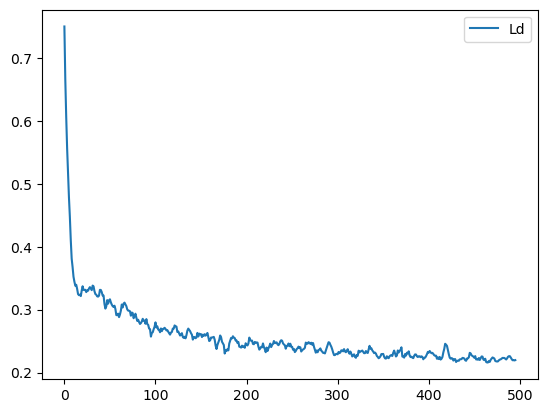

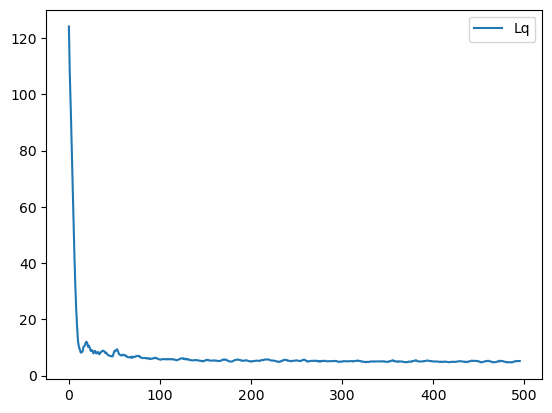

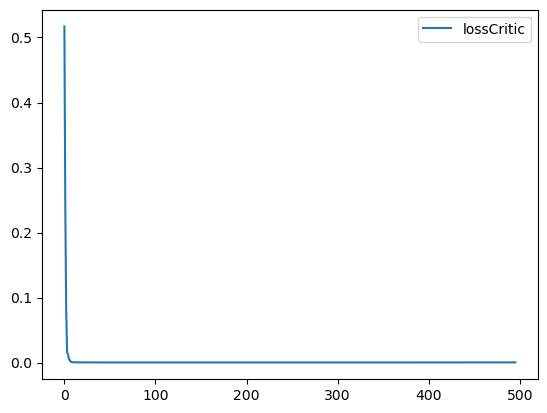

In [ ]:
def smooth(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

obv_idxs = -1000
window_size = 5
plt.plot(smooth(info['LdRecord'][obv_idxs:], window_size=window_size), label="Ld")
plt.legend()
plt.show()
plt.plot(smooth(info['LqRecord'][obv_idxs:], window_size=window_size), label="Lq")
plt.legend()
plt.show()
plt.plot(smooth(info['lossCriticRecord'][obv_idxs:], window_size=window_size), label="lossCritic")
plt.legend()
plt.show()